In [44]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
# Kmeans
from sklearn.cluster import KMeans
# silhouette score
from sklearn.metrics import silhouette_score

In [45]:
# load final_with_anomalies.parquet
df = pd.read_parquet("processed_data/final_with_anomalies.parquet")
df.shape

(421570, 29)

In [46]:
# show all columns
pd.set_option("display.max_columns", None)

In [47]:
df.columns

Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday', 'Temperature',
       'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4',
       'MarkDown5', 'CPI', 'Unemployment', 'Size', 'Has_Markdown', 'Week',
       'Month', 'Year', 'Rolling_Mean_4', 'Rolling_Std_4', 'Z_Score',
       'Pct_Deviation', 'Lag_1', 'Type_B', 'Type_C', 'IF_Anomaly',
       'LOF_Anomaly', 'High_Confidence_Anomaly'],
      dtype='object')

In [48]:
# creating store level features 

store_features = (
    df.groupby("Store")
      .agg(
          mean_sales=("Weekly_Sales", "mean"),
          sales_std=("Weekly_Sales", "std"),
          avg_pct_dev=("Pct_Deviation", "mean"),
          if_anomaly_rate=("IF_Anomaly", "mean"),
          high_conf_anomaly_rate=("High_Confidence_Anomaly", "mean"),
          markdown_rate=("Has_Markdown", "mean"),
          holiday_sales=("IsHoliday", "mean"),
          store_size=("Size", "first")
      )
      .reset_index()
)

store_features.head()


,Store,mean_sales,sales_std,avg_pct_dev,if_anomaly_rate,high_conf_anomaly_rate,markdown_rate,holiday_sales,store_size
0,1,21710.543621,27748.945511,0.005136,0.051738,0.000976,0.356989,0.070578,151315
1,2,26898.070031,33077.612059,0.012600,0.061340,0.000195,0.357785,0.070522,202307
2,3,6373.033983,14251.034807,0.006354,0.018814,0.001439,0.359119,0.070053,37392
3,4,29161.210415,34583.677814,0.003083,0.080997,0.001266,0.357866,0.070775,205863
4,5,5053.415813,8068.221050,0.005480,0.006890,0.000889,0.358151,0.071119,34875


In [49]:
store_features.shape

(45, 9)

In [50]:
store_features.isnull().sum()

Store                     0
mean_sales                0
sales_std                 0
avg_pct_dev               0
if_anomaly_rate           0
high_conf_anomaly_rate    0
markdown_rate             0
holiday_sales             0
store_size                0
dtype: int64

In [51]:
# Scale Features

seg_features = store_features.columns.tolist()[1:]

X = store_features[seg_features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [52]:
# Deciding the number of clusters using Elbow Method
inertia = []

for k in range(2, 8):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    # appending within-cluster sum of squares to inertia list for each k
    inertia.append(km.inertia_)

inertia
    


d:\apps\InstalledApplications\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
d:\apps\InstalledApplications\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
d:\apps\InstalledApplications\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
d:\apps\InstalledApplications\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: 

[231.73362520344088,
 182.88591022372793,
 155.09673661464896,
 127.90114066248523,
 114.62622790635912,
 94.6366542277455]

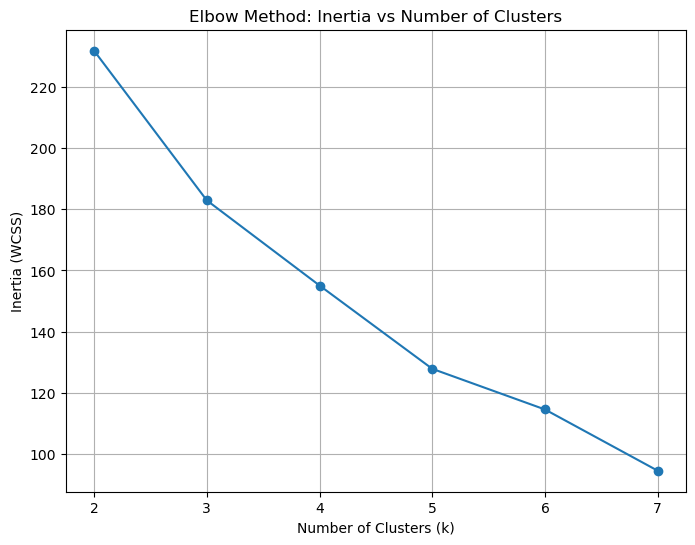

In [53]:
# plotting the inertia values
k_values = range(2, 8)

plt.figure(figsize=(8,6))
plt.plot(k_values, inertia, marker='o')
plt.title("Elbow Method: Inertia vs Number of Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (WCSS)")
plt.xticks(k_values)
plt.grid(True)
plt.show()



In [54]:
# Kmeans Segmentation with k=3
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
store_features["Cluster_KMeans3"] = kmeans.fit_predict(X_scaled)

d:\apps\InstalledApplications\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [55]:
# Checking the segmentation quality using silhouette score
silhouette_score(X_scaled, store_features["Cluster_KMeans3"])

0.3048440612797122

In [56]:
store_features.groupby("Cluster_KMeans3")[seg_features].mean()

,mean_sales,sales_std,avg_pct_dev,if_anomaly_rate,high_conf_anomaly_rate,markdown_rate,holiday_sales,store_size
Cluster_KMeans3,,,,,,,,
0,22700.000581,27478.604465,0.005658,0.051714,0.000647,0.357343,0.070463,191117.055556
1,11055.199319,14648.415108,-0.003909,0.013186,0.000676,0.359176,0.070401,101464.619048
2,8992.490185,13861.593709,0.058825,0.013454,0.000911,0.367616,0.069652,48679.666667


Cluster 0 - Large,high-volumn and high volatility stores.
    * mean_sales ~ 22.7k , sales_std ~ 27.5k , store_size  ~ 191k
    * if_anomaly_rate ~ 0.0517 (5.17%)
    * markdown_rate ~ 0.357 (35.7%) it means that 35.7% of the time, there is a markdown(discount) in this cluster.
    * Large, busy stores - volatile sales, many IF anomalies (global outliers)

Cluster 1 — Mid-volume, more stable stores
    * mean_sales ~ 11.1k, sales_std ~ 14.6k, store_size ~ 101k
    * if_anomaly_rate ~ 0.0132 (much lower than cluster 0)
    * avg_pct_dev slightly negative → small downwards bias on average
    * Business label: “Medium stores, more stable(based on fewer anomalies and smaller swings in sales) / normal behavior.”

Cluster 2 — Small stores, promotion-sensitive / higher pct deviation
    * mean_sales ~ 9.0k, sales_std ~ 13.9k, store_size ~ 48.7k
    * avg_pct_dev ~ 0.0588 (largest positive deviation on average)
    * markdown_rate ~ 0.368 (highest)
    * Business label: “Small, promo-driven stores — spikes relative to rolling mean (campaign-driven).”


The Clustering has separated the stores mostly by scale (mean_sales and store_size) and by behaviour (avg_pct_dev and IF anomaly rate).

Quality of Clustering:

For different k values(2,3,4,5,6,7) the inertia decreases smoothly. The elbow point is not very pronounced.It is due to the less number of records (45 stores), for such a case elbow method is often ambiguous.

Silhouette score for k= 3 is 0.3048. 
Interpretation : 0.7 - 1.0 : Strong clustering , 0.3 - 0.5 : Weak clustering (common in real world)
So , 0.3048 is acceptable for messy retail data.

k=3 is alright though k=5 might provide finer segmentation - We will check that now

In [57]:
# Kmeans Segmentation with k=5
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
store_features["Cluster_KMeans5"] = kmeans.fit_predict(X_scaled)
# Checking the segmentation quality using silhouette score
silhouette_score(X_scaled, store_features["Cluster_KMeans5"])

d:\apps\InstalledApplications\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


0.27338441570202754

In [58]:
store_features.groupby("Cluster_KMeans5")[seg_features].mean()

,mean_sales,sales_std,avg_pct_dev,if_anomaly_rate,high_conf_anomaly_rate,markdown_rate,holiday_sales,store_size
Cluster_KMeans5,,,,,,,,
0,26679.252040,32665.779946,-0.002179,0.077815,0.001327,0.356873,0.070521,195035.142857
1,19243.308358,23368.732607,0.009739,0.033251,0.000251,0.357924,0.070485,183265.923077
2,9054.281129,13487.929208,0.061931,0.011395,0.000383,0.367857,0.069984,51597.500000
3,10480.986022,13781.755055,-0.008948,0.008953,0.000342,0.358626,0.070328,100791.500000
4,11924.967066,17170.506748,0.010982,0.033299,0.003663,0.361432,0.069855,64330.000000


Insight : We find that k = 3 is giving better clustering quality than k = 5. The silhouette score for k=3 is higher than that for k=5, indicating that the clusters are more distinct and well-defined with k=3.

mean_sales 0.4971503723325702


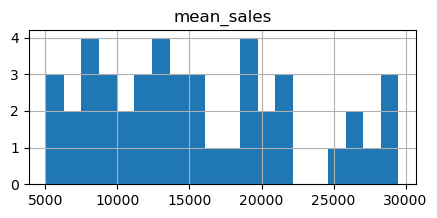

sales_std 0.6581260277649811


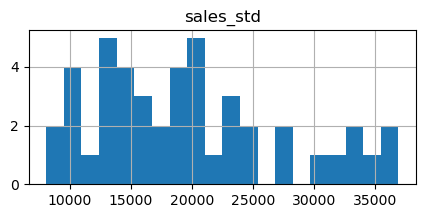

avg_pct_dev 2.292331882042626


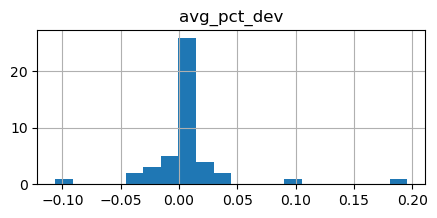

if_anomaly_rate 1.1136301796415595


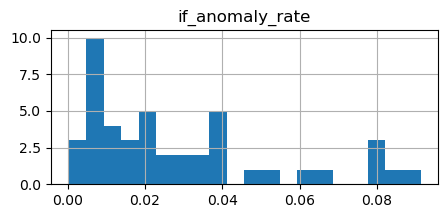

high_conf_anomaly_rate 2.1493773750807774


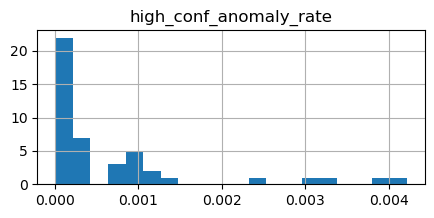

markdown_rate 1.6177884279318573


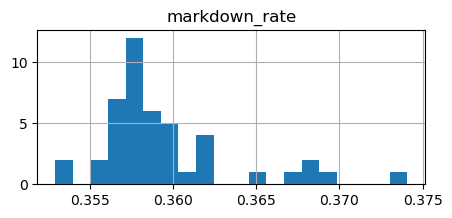

holiday_sales -0.418984121662502


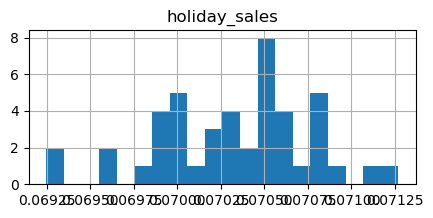

store_size -0.20006766031155365


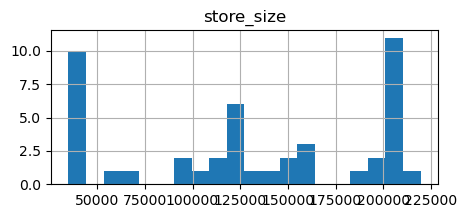

In [59]:
# Inspect Skewness and distributions for key features in the store_features dataframe

for col in seg_features:
    print(col , store_features[col].skew())
    plt.figure(figsize=(5,2))
    store_features[col].hist(bins=20)
    plt.title(col)
    plt.show()

In [60]:
for col in seg_features:
    print(col , store_features[col].skew())

mean_sales 0.4971503723325702
sales_std 0.6581260277649811
avg_pct_dev 2.292331882042626
if_anomaly_rate 1.1136301796415595
high_conf_anomaly_rate 2.1493773750807774
markdown_rate 1.6177884279318573
holiday_sales -0.418984121662502
store_size -0.20006766031155365


Transformations Decisions:

1. mean_sales skewness -> 0.497 : borderline symmetric , No transformation needed , Only scaling needed
2. sales_std skewness -> 0.658 : mild skew related to mean_sales , No transformation needed , Only scaling needed
3. avg_pct_dev skewness -> 2.29 : highly skewed , Transformation needed
4. if_anomaly_rate skewness -> 1.11 : moderately skewed , Transformation needed
5. high_conf_anomaly_rate skewness -> 2.15 : highly skewed , Transformation needed
6. markdown_rate skewness -> 1.62 : strong skewness , Transformation needed 
7. holiday_sales -> -0.42 : mild negative skew , No transformation needed
8. store_size -> -0.2 : nearly symmetric , No transformation needed , scaling only needed


Implementing Yeo-Johnson transformation for skewed features and then scaling all features using StandardScaler. After transformation and scaling, we will re-run KMeans clustering and evaluate the quality of clusters again using silhouette score, Davies-Bouldin Index and Calinski-Harabasz Index to see if there is an improvement in clustering quality.

In [61]:
from sklearn.preprocessing import PowerTransformer,StandardScaler

store_seg = store_features.copy()
to_transform = ["avg_pct_dev", "if_anomaly_rate", "high_conf_anomaly_rate", "markdown_rate"]

pt = PowerTransformer(method='yeo-johnson',standardize= False)
store_seg[to_transform] = pt.fit_transform(store_seg[to_transform])

In [62]:
scaler = StandardScaler()
X_scaled_pt = scaler.fit_transform(store_seg[seg_features])

In [63]:
# # Deciding the number of clusters using Elbow Method
inertia = []

for k in range(2, 8):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled_pt)
    inertia.append(km.inertia_)

inertia

d:\apps\InstalledApplications\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
d:\apps\InstalledApplications\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
d:\apps\InstalledApplications\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
d:\apps\InstalledApplications\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: 

[192.62229062026185,
 156.08774851368764,
 129.29837194869245,
 110.03591761692755,
 91.06885247888646,
 83.84975934491473]

Better WCSS values that before transformation, indicating that the clusters are more compact and well-defined after transformation. This suggests that the transformations have helped to improve the clustering quality by making the data more suitable for K-means.

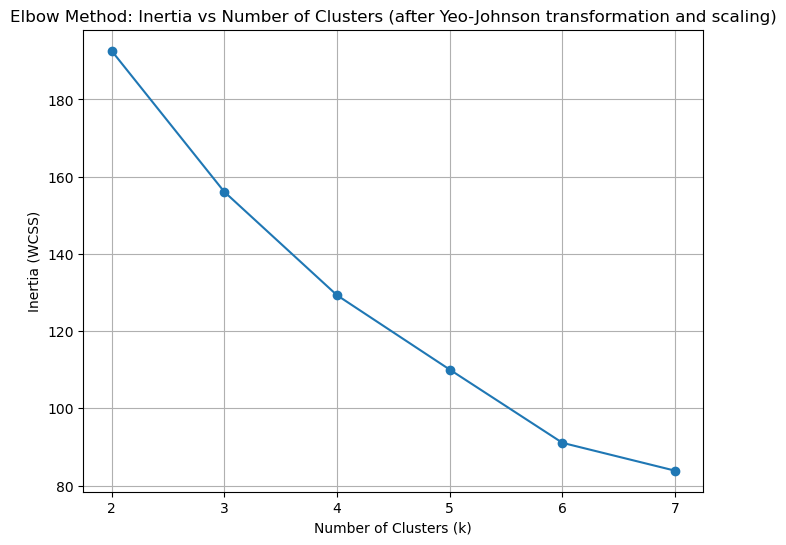

In [64]:
# plotting the inertia values
k_values = range(2, 8)

plt.figure(figsize=(8,6))
plt.plot(k_values, inertia, marker='o')
plt.title("Elbow Method: Inertia vs Number of Clusters (after Yeo-Johnson transformation and scaling)")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (WCSS)")
plt.xticks(k_values)
plt.grid(True)
plt.show()


Based on Elbow method , the best value seems to be k = 6 as elbow point is more pronounced at k = 6.

In [65]:
# Silhoutte loop to choose k 
sil_scores = {}
for k in range(2, 8):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled_pt)
    sil_scores[k] = silhouette_score(X_scaled_pt, labels)
sil_scores

d:\apps\InstalledApplications\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
d:\apps\InstalledApplications\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
d:\apps\InstalledApplications\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
d:\apps\InstalledApplications\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: 

{2: 0.3318935883434587,
 3: 0.2951339061491144,
 4: 0.2726498324007868,
 5: 0.29094974504885485,
 6: 0.3018259212575956,
 7: 0.2944952206513297}

The best two scores are for k = 2 and k = 6.

The highest silhouette score is for k=2 but only two clusters may be too coarse to be useful.We will try k =2 at the end to see if it gives us any useful insights.Right now we will check k = 6 as it gives more detailed segmentation and still has a decent silhouette score.

At k=6, the score is 0.302 , which is slightly lower that that for k = 2 , but still decent and it gives more segmentation details. 

Our goal is business segmentation and richer insights, k = 6 is a reasonable choice , it balances interpretability with acceptable silhouette score.

In [66]:
kmeans = KMeans(n_clusters=6, random_state=42, n_init=10)
store_features["Cluster_pt_KMeans6"] = kmeans.fit_predict(X_scaled_pt)

# silhouette_score
print("Silhouette Score:", silhouette_score(X_scaled_pt, store_features["Cluster_pt_KMeans6"]))

store_cluster_profile_kmeans6 = store_features.groupby("Cluster_pt_KMeans6")[seg_features].mean()
store_cluster_profile_kmeans6

d:\apps\InstalledApplications\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Silhouette Score: 0.3018259212575956


,mean_sales,sales_std,avg_pct_dev,if_anomaly_rate,high_conf_anomaly_rate,markdown_rate,holiday_sales,store_size
Cluster_pt_KMeans6,,,,,,,,
0,19517.166566,23483.179972,0.010707,0.032624,0.000135,0.357884,0.070440,188732.636364
1,8371.493806,12561.624097,0.075104,0.006613,0.000101,0.363268,0.069770,53944.000000
2,11401.792373,16839.297157,0.008030,0.022586,0.001965,0.362326,0.069851,71472.125000
3,10086.643830,12858.426911,0.000514,0.008532,0.000256,0.359659,0.070594,104778.153846
4,26058.163487,32051.175641,-0.001265,0.074556,0.001283,0.356888,0.070528,189570.125000
5,15733.313136,18556.351564,-0.106278,0.015113,0.000101,0.361497,0.069987,120653.000000


Explaination of the clusters with k=6:

### Cluster 4 — Very Large, Highly Volatile Stores (Risk-heavy)

#### 📊 Stats
- **Mean Sales**: ≈ 26k (highest)
- **Sales Std Dev**: ≈ 32k (very high volatility)
- **IF Anomaly Rate**: ≈ 7.45% (highest)
- **Store Size**: ≈ 189k

#### 🧠 Interpretation
These are flagship, metro, or high-footfall stores.  
Their large volume naturally leads to more global anomalies.

Likely impacted by:
- Bulk purchases  
- Supply chain irregularities  
- Big promotions  

#### 🏷️ Business Label
**“High-volume, high-risk stores requiring tighter anomaly monitoring & robust inventory buffers.”**


### Cluster 0 — Large but More Controlled Stores

#### 📊 Stats
- **Mean Sales**: ≈ 19.5k  
- **Sales Std Dev**: ≈ 23.5k  
- **IF Anomaly Rate**: ≈ 3.26% (lower than Cluster 4)  
- **Store Size**: ≈ 188k  

#### 🧠 Interpretation
Large stores, but with better operational control.  
Still volatile, yet less risky compared to Cluster 4.

#### 🏷️ Business Label
**“Large, mature stores with managed volatility.”**

### Cluster 2 — Mid-size Stores with Elevated High-Confidence Anomalies

#### 📊 Stats
- **Mean Sales**: ≈ 11.4k  
- **High-Confidence Anomaly Rate**: ≈ 0.196% (highest among clusters)  
- **Store Size**: ≈ 71k  

#### 🧠 Interpretation
These stores don’t show many global anomalies.  
However, when anomalies occur, they are strong and consistent.

Possible causes:
- Local events  
- Data reporting issues  
- Poor forecasting calibration  

#### 🏷️ Business Label
**“Mid-sized stores with fewer but sharper irregularities — priority for investigation.”**

### Cluster 3 — Stable, Medium Stores

#### 📊 Stats
- **Mean Sales**: ≈ 10k  
- **Anomaly Rates**: Low  
- **Avg % Deviation**: ≈ near zero  
- **Store Size**: ≈ 105k  

#### 🧠 Interpretation
These stores exhibit predictable demand with minimal surprises.  
They are the best candidates for automated forecasting due to their stability.

#### 🏷️ Business Label
**“Stable, predictable stores suitable for baseline forecasting models.”**

### Cluster 1 — Small, Promotion-driven Stores

#### 📊 Stats
- **Mean Sales**: ≈ 8.3k  
- **Avg % Deviation**: ≈ 0.075 (highest)  
- **Markdown Rate**: High  
- **Store Size**: ≈ 54k  

#### 🧠 Interpretation
Sales spike relative to the rolling mean, showing strong promotion sensitivity.  
Not many anomalies overall, but frequent relative jumps tied to campaigns.

#### 🏷️ Business Label
**“Small, promotion-sensitive stores with campaign-driven demand spikes.”**

### Cluster 5 — Declining or Underperforming Stores

#### 📊 Stats
- **Avg % Deviation**: ≈ −0.106 (strong negative)  
- **Sales**: Moderate  
- **Volatility**: Moderate  

#### 🧠 Interpretation
These stores show persistent underperformance compared to recent trends.  

Possible causes:
- Demand saturation  
- Local competition  
- Store fatigue  

#### 🏷️ Business Label
**“Stores with declining sales momentum — candidates for intervention or restructuring.”**

Creating PCA plot for visualization.It confirms that clusters identified by KMeans occupy distince regions in the reduced dimensional space, supporting validity of segmentation.

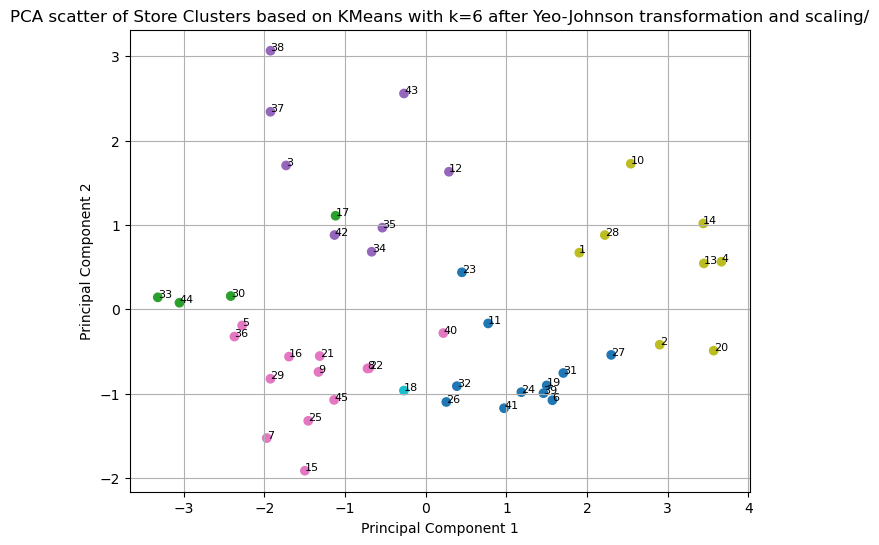

In [67]:
# Visualize the clusters using PCA


from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pc = pca.fit_transform(X_scaled_pt)
plt.figure(figsize=(8,6))
plt.scatter(pc[:,0], pc[:,1], c=store_features["Cluster_pt_KMeans6"], cmap="tab10")
for i,s in enumerate(store_features["Store"]):
    plt.text(pc[i,0], pc[i,1], str(s), fontsize=8)
plt.title("PCA scatter of Store Clusters based on KMeans with k=6 after Yeo-Johnson transformation and scaling/")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()

2nd Clustering Algorithm : Agglomerative Hierarchical Clustering

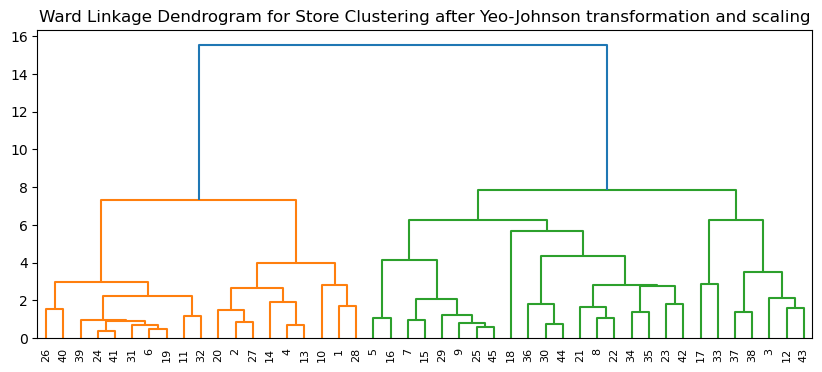

In [68]:
# Hierarchical Clustering and Dendrogram implemented on the transformed and scaled features.

import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist , squareform 

Z = sch.linkage(X_scaled_pt, method='ward')
plt.figure(figsize=(10, 4))
dn = sch.dendrogram(Z, labels=store_features["Store"].values, leaf_rotation=90)
plt.title("Ward Linkage Dendrogram for Store Clustering after Yeo-Johnson transformation and scaling")
plt.show()

From the dendrogram , I can see that there are 5 main clusters.We will get the cluster labels for 5 clusters. Other good cluster number seems to be 3.We will check both 3 and 5 clusters to see if they give us any useful insights.

In [69]:
# From the dendrogram , I can see that there are 5 main clusters.We will get the cluster labels for 5 clusters 

from scipy.cluster.hierarchy import fcluster

cluster_labels = fcluster(Z, t=5, criterion='maxclust')
store_features["HC_Cluster5"] = cluster_labels

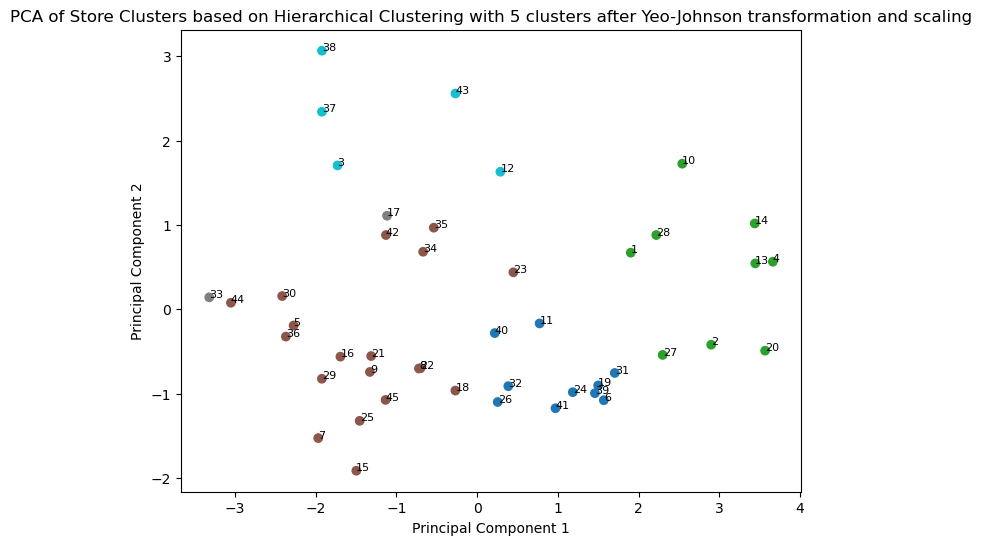

In [70]:
# Visualize the clusters using PCA
pca = PCA(n_components=2)
pc = pca.fit_transform(X_scaled_pt)
plt.figure(figsize=(8,6))
plt.scatter(pc[:,0], pc[:,1], c=store_features["HC_Cluster5"], cmap="tab10")
for i,s in enumerate(store_features["Store"]):
    plt.text(pc[i,0], pc[i,1], str(s), fontsize=8)

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA of Store Clusters based on Hierarchical Clustering with 5 clusters after Yeo-Johnson transformation and scaling")
plt.show()

In [71]:
# Silhouette Score for Hierarchical Clustering  
print("Silhouette Score for Hierarchical Clustering with 5 clusters:", silhouette_score(X_scaled_pt, store_features["HC_Cluster5"]))

Silhouette Score for Hierarchical Clustering with 5 clusters: 0.2497289471157545


In [72]:
# creating store_cluster_profile_HC5
store_cluster_profile_HC5 = store_features.groupby("HC_Cluster5")[seg_features].mean()
store_cluster_profile_HC5

,mean_sales,sales_std,avg_pct_dev,if_anomaly_rate,high_conf_anomaly_rate,markdown_rate,holiday_sales,store_size
HC_Cluster5,,,,,,,,
1,18384.929961,22542.858273,0.010728,0.029541,0.000189,0.358165,0.070536,191242.500000
2,25921.365826,31792.036025,-0.000436,0.071770,0.001151,0.356962,0.070505,191193.888889
3,10865.497227,14027.025908,-0.004891,0.010399,0.000277,0.360218,0.070317,96136.947368
4,9341.403845,12636.356486,0.148351,0.009455,0.000203,0.364515,0.069942,66439.000000
5,10489.058041,16411.609538,0.013119,0.026129,0.002680,0.362621,0.069773,54058.400000


In [73]:
# Trying different cluster validity metrics : Davies-Bouldin Index and Calinski-Harabasz Index

from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score

print("Davies-Bouldin Index for KMeans Clustering with 6 clusters:", davies_bouldin_score(X_scaled_pt, store_features["Cluster_pt_KMeans6"]))
print("Calinski-Harabasz Index for KMeans Clustering with 6 clusters:", calinski_harabasz_score(X_scaled_pt, store_features["Cluster_pt_KMeans6"]))

# for hierarchical clustering
print("Davies-Bouldin Index for Hierarchical Clustering with 5 clusters:", davies_bouldin_score(X_scaled_pt, store_features["HC_Cluster5"]))
print("Calinski-Harabasz Index for Hierarchical Clustering with 5 clusters:", calinski_harabasz_score(X_scaled_pt, store_features["HC_Cluster5"]))


Davies-Bouldin Index for KMeans Clustering with 6 clusters: 0.9804661851640395
Calinski-Harabasz Index for KMeans Clustering with 6 clusters: 19.17958668766179
Davies-Bouldin Index for Hierarchical Clustering with 5 clusters: 1.0640663662461634
Calinski-Harabasz Index for Hierarchical Clustering with 5 clusters: 16.83199391171487


Hierarchical Clustering with 5 clusters provided useful validation, but KMeans with k=6 using transformed(Yeo-Johnson normalized and scaled) features offered better compactness and interpretability.

The metrices silhouette score , Davies-Bouldin Index and Calinski-Harabasz Index all indicate that KMeans with k=6 is the superior choice for our segmentation task.

In [74]:
# Checking cluster sizes 

print("Cluster Sizes for KMeans Clustering with 6 clusters:")
print(store_features["Cluster_pt_KMeans6"].value_counts())

print("Cluster Sizes for Hierarchical Clustering with 5 clusters:")
print(store_features["HC_Cluster5"].value_counts())

Cluster Sizes for KMeans Clustering with 6 clusters:
Cluster_pt_KMeans6
3    13
0    11
2     8
4     8
1     4
5     1
Name: count, dtype: int64
Cluster Sizes for Hierarchical Clustering with 5 clusters:
HC_Cluster5
3    19
1    10
2     9
5     5
4     2
Name: count, dtype: int64


Also Trying Kmeans clustering with k = 2 

In [75]:
kmeans_2 = KMeans(n_clusters=2, random_state=42, n_init=10)
store_features["Cluster_pt_KMeans2"] = kmeans_2.fit_predict(X_scaled_pt)

# silhouette_score
print("Silhouette Score for KMeans Clustering with 2 clusters:", silhouette_score(X_scaled_pt, store_features["Cluster_pt_KMeans2"]))

store_cluster_profile_kmeans2 = store_features.groupby("Cluster_pt_KMeans2")[seg_features].mean()
store_cluster_profile_kmeans2

Silhouette Score for KMeans Clustering with 2 clusters: 0.3318935883434587


d:\apps\InstalledApplications\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


,mean_sales,sales_std,avg_pct_dev,if_anomaly_rate,high_conf_anomaly_rate,markdown_rate,holiday_sales,store_size
Cluster_pt_KMeans2,,,,,,,,
0,10444.615274,14256.799040,0.010195,0.012814,0.000752,0.361105,0.070215,87320.076923
1,22271.270533,27090.757096,0.005666,0.050279,0.000618,0.357465,0.070477,189085.263158


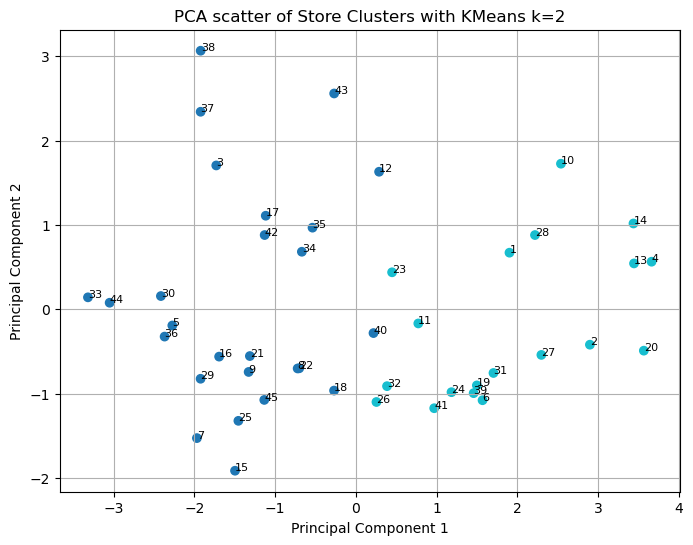

In [76]:
# Visualize the clusters using PCA for KMeans with 2 clusters


from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pc = pca.fit_transform(X_scaled_pt)
plt.figure(figsize=(8,6))
plt.scatter(pc[:,0], pc[:,1], c=store_features["Cluster_pt_KMeans2"], cmap="tab10")
for i,s in enumerate(store_features["Store"]):
    plt.text(pc[i,0], pc[i,1], str(s), fontsize=8)
plt.title("PCA scatter of Store Clusters with KMeans k=2")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()

Kmeans Clustering with k = 2 gives the best silhouette score of 0.33.Even its PCA visualizations shows good distinct clusters.Cluster profile for k = 2 also shows quite distinct values for most of the important clustering features like mean_sales , sales_std , avg_pct_dev , if_anomaly_rate and store_size.

Now we will try the Heirarchical clustering with 3 clusters to see if it gives us any useful insights.

In [77]:
# HC with 3 clusters
from scipy.cluster.hierarchy import fcluster
Z = sch.linkage(X_scaled_pt, method='ward')
cluster_labels_hc3 = fcluster(Z, t=3, criterion='maxclust')
store_features["HC_Cluster3"] = cluster_labels_hc3

# silhouette_score
print("Silhouette Score for Hierarchical Clustering with 3 clusters:", silhouette_score(X_scaled_pt, store_features["HC_Cluster3"]))

store_cluster_profile_hc3 = store_features.groupby("HC_Cluster3")[seg_features].mean()
store_cluster_profile_hc3

Silhouette Score for Hierarchical Clustering with 3 clusters: 0.29180746972260246


,mean_sales,sales_std,avg_pct_dev,if_anomaly_rate,high_conf_anomaly_rate,markdown_rate,holiday_sales,store_size
HC_Cluster3,,,,,,,,
1,21954.820634,26924.047735,0.005439,0.049545,0.000645,0.357595,0.070521,191219.473684
2,10865.497227,14027.025908,-0.004891,0.010399,0.000277,0.360218,0.070317,96136.947368
3,10161.156842,15332.965809,0.051757,0.021365,0.001972,0.363162,0.069822,57595.714286


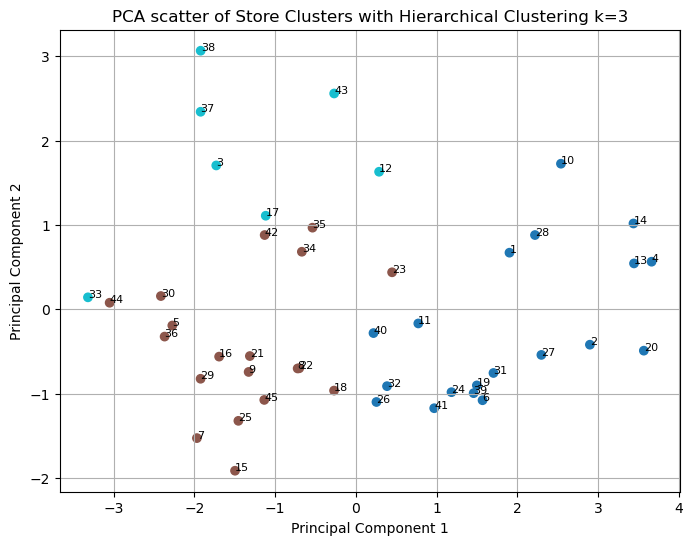

In [78]:
# Visualize the clusters using PCA for Hierarchical Clustering with 3 clusters
pca = PCA(n_components=2)
pc = pca.fit_transform(X_scaled_pt)
plt.figure(figsize=(8,6))
plt.scatter(pc[:,0], pc[:,1], c=store_features["HC_Cluster3"], cmap="tab10")
for i,s in enumerate(store_features["Store"]):
    plt.text(pc[i,0], pc[i,1], str(s), fontsize=8)
plt.title("PCA scatter of Store Clusters with Hierarchical Clustering k=3")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()

In [79]:
# Comparing Davies-Bouldin Index and Calinski-Harabasz Index for KMeans with 2 clusters and Hierarchical Clustering with 3 clusters

print("Davies-Bouldin Index for KMeans Clustering with 2 clusters:", davies_bouldin_score(X_scaled_pt, store_features["Cluster_pt_KMeans2"]))
print("Calinski-Harabasz Index for KMeans Clustering with 2 clusters:", calinski_harabasz_score(X_scaled_pt, store_features["Cluster_pt_KMeans2"]))
print("Davies-Bouldin Index for Hierarchical Clustering with 3 clusters:", davies_bouldin_score(X_scaled_pt, store_features["HC_Cluster3"]))
print("Calinski-Harabasz Index for Hierarchical Clustering with 3 clusters:", calinski_harabasz_score(X_scaled_pt, store_features["HC_Cluster3"]))

Davies-Bouldin Index for KMeans Clustering with 2 clusters: 1.1252300404953586
Calinski-Harabasz Index for KMeans Clustering with 2 clusters: 27.318964416754806
Davies-Bouldin Index for Hierarchical Clustering with 3 clusters: 1.4051269461820342
Calinski-Harabasz Index for Hierarchical Clustering with 3 clusters: 19.455037919340516


In [80]:
# save the store_features dataframe as parquet file
store_features.to_parquet("processed_data/store_features.parquet", index=False)


Different Metrics (silhouette score , Davies-Bouldin Index and Calinski-Harabasz Index) all indicate different aspects of clustering.

Silhoutte Score -> Higher is better -> It gives sense of how well separated the clusters are and also the compactness of the clusters. It ranges from -1 to 1, where 1 means well-separated clusters and -1 means overlapping clusters.

Davies-Bouldin Index -> Lower is better -> It measures the average similarity between clusters, where similarity is a measure that compares the distance between clusters with the size of the clusters themselves. A lower score indicates better clustering.

Calinski-Harabasz Index -> Higher is better -> It measures the ratio of between-cluster variance to within-cluster variance. A higher score indicates better-defined clusters.

Decisioning on the best clustering approach:

*First Clustering Approach : KMeans with k = 6*

silhoutte = 0.301 
DBI = 0.98 ( best among all approaches)
CH = 19.18 (reasonable)

* Each of its cluster has a distinct business story
* Good for forecasting usefullness
* Therefore Strong,balanced,business-usable segmentation

*Second Clustering Approach : AGC with k = 5*

silhoutte = 0.249 (weaker than KMeans k=6)
DBI = 1.05 (worse than KMeans k=6)
CH = 16.83 (worse than KMeans k=6)

* Inferior to KMeans k=6 in all metrics
* Clusters less distinct and less actionable

*Third Clustering Approach : Kmeans with k = 2*
silhoutte = 0.33 (highest silhouette score)
DBI = 1.12 (worse than KMeans k=6)
CH = 27.3 (highest)

* But this is misleading as k=2 almost always inflated CH index and silhouette score due to having only 2 clusters
* Clusters are too broad and not actionable for business segmentation.It collapses everything into : BigStores vs Small Stores which is not very useful for our purpose.

*Fourth Clustering Approach : AGC with k = 3*
silhoutte = 0.28 (decent but still weaker than KMeans k=6)
DBI = 1.40 (worse than KMeans k=6)
CH = 19.45 (similar to KMeans k=6)
* Still inferior to KMeans k=6 in silhouette and DBI.No advantage over KMeans k=6.



### Final Clustering Decision:
**KMeans with k=6 using transformed features is the best clustering approach for our store segmentation.**

In [82]:
# saving store cluster profiles


# store_cluster_profile_kmeans2.to_parquet("processed_data/store_cluster_profile_kmeans2.parquet")
# store_cluster_profile_hc3.to_parquet("processed_data/store_cluster_profile_hc3.parquet")
store_cluster_profile_kmeans6.to_parquet("processed_data/store_cluster_profile_kmeans6.parquet")
# store_cluster_profile_HC5.to_parquet("processed_data/store_cluster_profile_hc5.parquet")